# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012


In [3]:
rec_size = 90

## Top n recommendations

return seuqneces with top n ucb score. 

In [4]:
top_n = Top_n_ucb(known_df, kernel_name='WD_Kernel_Shift', l=6, s=1,
                 embedding='label', alpha=6, rec_size=rec_size, beta=1)

In [5]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (1055, 20)
X test shape:  (3961, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg


## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [6]:
gpbucb = GP_BUCB(known_df, kernel_name='WD_Kernel_Shift', l=6, s=1,
                embedding='label', alpha=6, rec_size=rec_size, beta=1)

In [7]:
gpbucb_rec_df = gpbucb.run_experiment()

X train shape:  (1055, 20)
X test shape:  (3961, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (177, 15)
X train shape:  (1056, 20)
X test shape:  (3960, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (178, 15)
X train shape:  (1057, 20)
X test shape:  (3959, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (179, 15)
X train shape:  (1058, 20)
X test shape:  (3958, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (180, 15)
X train shape:  (1059, 20)
X test shape:  (3957, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (181, 15)
X train shape:  (1060, 20)
X test shape:  (3956, 20)
create kernel instance
init kernel
finish creating kernel instance


finish reg
train size  (223, 15)
X train shape:  (1102, 20)
X test shape:  (3914, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (224, 15)
X train shape:  (1103, 20)
X test shape:  (3913, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (225, 15)
X train shape:  (1104, 20)
X test shape:  (3912, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (226, 15)
X train shape:  (1105, 20)
X test shape:  (3911, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (227, 15)
X train shape:  (1106, 20)
X test shape:  (3910, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (228, 15)
X train shape:  (1107, 20)
X test shape:  (3909, 20)
create kernel instance
init kernel

## Recommendation results

In [8]:
gpbucb_rec_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,STD,Unnamed: 0,train_test,label,pred mean,pred std,ucb
0,3385,NaN,NaN,NaN,TTTAAGATGCTATTATACAT,TGCTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.775773,0.812053,1.587827
1,1582,NaN,NaN,NaN,TTTAAGAGCGTATTATACAT,GCGTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.716166,0.805926,1.522092
2,3321,NaN,NaN,NaN,TTTAAGATGGTATTATACAT,TGGTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.756108,0.756684,1.512792
3,2393,NaN,NaN,NaN,TTTAAGACGCTATTATACAT,CGCTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.730601,0.777935,1.508535
4,1534,NaN,NaN,NaN,TTTAAGAGCGAATTATACAT,GCGAAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.688211,0.813586,1.501797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1894,NaN,NaN,NaN,TTTAAGAGTCTAGTATACAT,GTCTAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.499736,0.731508,1.231244
86,2283,NaN,NaN,NaN,TTTAAGACGGAAGTATACAT,CGGAAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.557481,0.671537,1.229018
87,1646,NaN,NaN,NaN,TTTAAGAGCCTGGTATACAT,GCCTGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.518943,0.708806,1.227750
88,2892,NaN,NaN,NaN,TTTAAGACTCTGTTATACAT,CTCTGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.560118,0.667149,1.227268


In [9]:
top_n_rec_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,STD,Unnamed: 0,train_test,label,pred mean,pred std,ucb
3561,3385,NaN,NaN,NaN,TTTAAGATGCTATTATACAT,TGCTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.775773,0.812053,1.587827
2569,2393,NaN,NaN,NaN,TTTAAGACGCTATTATACAT,CGCTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.730601,0.797509,1.528109
3497,3321,NaN,NaN,NaN,TTTAAGATGGTATTATACAT,TGGTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.756108,0.769968,1.526076
1758,1582,NaN,NaN,NaN,TTTAAGAGCGTATTATACAT,GCGTAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.716166,0.807945,1.524110
1710,1534,NaN,NaN,NaN,TTTAAGAGCGAATTATACAT,GCGAAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.688211,0.822879,1.511090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,1535,NaN,NaN,NaN,TTTAAGAGCGAGATATACAT,GCGAGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.592702,0.699605,1.292307
1716,1540,NaN,NaN,NaN,TTTAAGAGCGACGTATACAT,GCGACG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.454963,0.836779,1.291742
2568,2392,NaN,NaN,NaN,TTTAAGACGCTACTATACAT,CGCTAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.486225,0.804683,1.290907
3437,3261,NaN,NaN,NaN,TTTAAGATGATGGTATACAT,TGATGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.522553,0.767584,1.290137


In [10]:
top_n_rec_df.index

Int64Index([3561, 2569, 3497, 1758, 1710, 2072, 3565, 3451, 1569, 2505, 3563,
            1726, 1714, 1883, 3533, 1760, 3469, 3465, 2573, 1820, 1762, 1712,
            1730, 3501, 3499, 2571, 1724, 2461, 1694, 3435, 3064, 1708, 2541,
            3454, 1742, 2074, 2076, 3513, 3559, 1887, 2044, 1855, 1573, 3529,
            2507, 1885, 3560,  733, 1571, 2509, 3452, 2477, 1836,  780, 3481,
            2474, 1824, 3531, 1698, 2464, 3449, 4064, 2321, 1822, 1867, 1541,
            2567, 1696, 2521, 3439,  592, 3527, 3467,  351, 3624,  491, 2024,
            2537, 2462, 1505, 2070, 3496, 3311, 1728, 2040, 1711, 1716, 2568,
            3437,  748],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

init kernel
init kernel
init kernel


Text(0.5, 1.0, 'GP_BUCB hist')

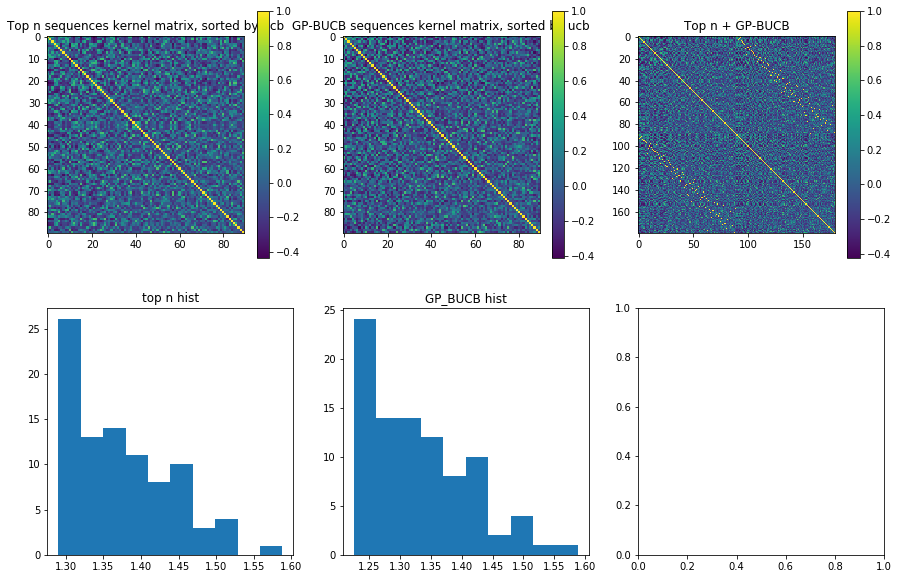

In [11]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(wd_kernel(l=6, features = np.asarray(top_n_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(wd_kernel(l=6, features = np.asarray(gpbucb_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][2])
a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [12]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  85


In [13]:
with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='a') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_alpha6')
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_alpha6')